In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import itertools as it

In [2]:
sc.settings.verbosity = 4

In [3]:
prefix = '/data/xyzeq/'

## 2. Build the HexMap
Instead of relying on matplotlib, for many reasons I've decided to just build the image manually using a numpy array.

When considering the hexagons:
1. We want something as small as possible because for super resolution we will be registering to _pixel_ resolution. 
2. We need something that stacks. I don't know the theory or jargon around this, but I've determined (mostly through trial and error) we need something with an even number of pixels per side to prevent single-pixel points on the sides, as those don't stack.

I've come to the conclusion that the smallest, most-hexagon-like figure we can generate is the one that fits inside a 12 x 12 pixel grid.

In [4]:
myhex = np.zeros((12,12)) 

In [5]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

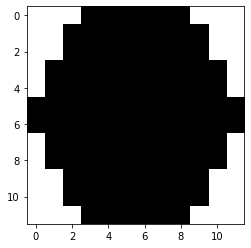

In [6]:
plt.imshow(myhex, cmap='binary');

Our hexagon has 6 pixel-long sides on top and bottom. If it were a true hexagon, the pixels on the vertical sides would also be 6 units long. We can try to measure one by using the length of the right triangle formed from the 3 pixels jutting out and 6 pixels high, which ends up creating a hypotenuse vertical side of theortical 6.71 units long, so 6 ~ 6.7, I'd say is close enough (~10% off) to true hexagon. The 12-pixel-long hexagon also has the added benefit of spatial resolution to around the diameter of a cell (500/12 is 40 um, roughly the size of what I'd imagine are the largest cells we'll be picking up). 

Now building the array of hexagons. I will mark the location of key points of each hexagons in a lookup dataframe called `hex_coords` so I don't have to build it everytime I need to fill in new values.

In [7]:
dim_x = 42
dim_y = 18

In [8]:
# make a lookup table, so that I don't have to do all these calculations again
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,dim_x+1), range(1,dim_y+1)], names=['X','Y']),
                          columns=['hex_xstart','hex_ystart', 'center_xstart', 'center_ystart', 'hex_xend', 'hex_yend'])

for y, x in it.product(range(1,dim_y+1),range(1,dim_x+1)):
    xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
    ystart = (y-1)*12
    if x % 2 == 0:  
        ystart = ystart + 6

    # make a lookup table, so that I don't have to do all these calculations again
    hex_coords.loc[(x,y),'hex_xstart'] = xstart
    hex_coords.loc[(x,y),'hex_ystart'] = ystart
    hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
    hex_coords.loc[(x,y),'center_ystart'] = ystart + 5
    hex_coords.loc[(x,y),'hex_xend'] = xstart + 12
    hex_coords.loc[(x,y),'hex_yend'] = ystart + 12
# hex_coords = hex_coords.astype(np.uint8) # definitely don't convert to integers, it will mess things up, not quite sure how exactly at the current moment

Now fill in the hex array with random colors to show it works.

In [ ]:
img = list()
for color in ['r','g','b']:
    hex_array = np.zeros((int((dim_y + 0.5)*12),int((dim_x+0.5)*9) - 1)) # these are calculated to perfectly encapsulate the 19 x 43 well array
    for y, x in it.product(range(1,dim_y+1),range(1,dim_x+1)):
        
        val = np.random.choice(range(50,255))
        
        xstart = hex_coords.loc[(x,y),'hex_xstart']
        ystart = hex_coords.loc[(x,y),'hex_ystart']

        yend = hex_coords.loc[(x,y),'hex_yend']
        xend = hex_coords.loc[(x,y),'hex_xend']
        
        current_hex = hex_array[ystart:yend,xstart:xend]
        hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
    img.append(hex_array)
img = np.stack(img, axis=2).astype(np.uint8)
factor = 20 # bigger factor means smaller overall figure size
plt.figure(figsize=(400/factor,220/factor)) # chose this size to keep the aspect ratio
plt.imshow(img, cmap='binary');

Okay, this is where this notebook deviates from `make.images.ipynb` from which it is derived. Instead of building a giant `hex_coords` dataframe that only goes up to ten layers, I've created a function that iteratively finds layers from a given number of center coordinates. I believe it has superior runtime and definitely a lower memory footprint.

In [10]:
def hex_marked(coords_mark, ax='None'):
    assert type(coords_mark) == set
    mark_hex = [(y, x) for x, y in coords_mark]
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((int((dim_y + 0.5)*12),int((dim_x+0.5)*9) - 1)) # these are calculated to perfectly encapsulate the 19 x 43 well array
        coords = set(it.product(range(1,dim_y+1),range(1,dim_x+1)))
        gray = coords.difference(mark_hex)
        for y, x in coords:
            if (y, x) in gray:
                val = np.random.choice(range(80))
            else:
                val = np.random.choice(range(100,255))

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    if ax == 'None':
        plt.figure(figsize=(400/40,220/40)) # chose this size to keep the aspect ratio
        plt.imshow(img, cmap='binary');
    else:
        ax.imshow(img, cmap='binary')
        return ax

In [11]:
def immediate_neighbors(x, y):
    if x % 2 == 0:
        neighbors = np.array([(x-1, y+1), (x, y+1), (x+1, y+1), (x-1, y), (x+1, y), (x, y-1)])
    else:
        neighbors = np.array([(x-1, y-1), (x, y-1), (x+1, y-1), (x-1, y), (x+1, y), (x, y+1)])
    
    neighbors = np.array([i for i in neighbors if not np.any(i <= 0) # remove negative positions
                          and not np.any(i[0] > dim_x) 
                          and not np.any(i[1] > dim_y)]) # remove those that are outside array bounds
    neighbors = set(tuple(i) for i in neighbors) # convert to set for easier manipulation alter
    return neighbors

In [12]:
def get_layers(center_coords, layers, plot=False, include_center=False, mask='None'):
    assert type(center_coords) == set
    
    layer_coords = list()
    last_layer = center_coords
#     return last_layer
    if include_center:
        layer_coords.append(last_layer)
        if plot:
            hex_marked(last_layer)
    
    current_neighbors = [immediate_neighbors(x, y) for x, y in last_layer]
    current_layer = current_neighbors[0].union(*current_neighbors[1:]).difference(last_layer)
    if mask == 'None':
        layer_coords.append(current_layer)
    else:
        layer_coords.append(current_layer.intersection(mask))
    if plot:
        hex_marked(current_layer)
        
    for _ in range(layers-1):
        next_neighbors = [immediate_neighbors(x, y) for x, y in current_layer]
        if len(next_neighbors) == 0:
            if include_center:
                print('No more layers, returning only %d layers + center' % (len(layer_coords) - 1))
            else:
                print('No more layers, returning only %d layers' % len(layer_coords))
            break
        next_layer = next_neighbors[0].union(*next_neighbors[1:]).difference(current_layer).difference(last_layer)
        if mask == 'None':
            layer_coords.append(current_layer)
        else:
            layer_coords.append(next_layer.intersection(mask))
        if plot:
            hex_marked(next_layer)
            
        last_layer = current_layer
        current_layer = next_layer
    return layer_coords

In [27]:
def get_colors(df, cts, color=True, prop_den=None, clip_cts=None, clip_tots=None):
    '''
    This function takes in the counts of each cell type from the DataFrame and 
    will generate color values based on the proportion of cells in each well
    that are the celltype(s) of interest. If color set to False, will just
    return the actual proportion of each cell type not scaled to RGB values.
    
    cts is a list of celltypes.
    
    For calculating proportion, will use a denomintaor of the total of only the provided 
    cell types (prop_den='cts') or the total of all cells (prop_den='tot'). If not
    provided, for len(ct) == 1 will set to 'tot', else will use 'cts'.
    
    `clip_cts` (list, same length as cts) will floor counts to zero before doing
    proportion calculations. `clip_tots` (int) will floor color values to zero
    of wells that don't contain at least that many cells.
    
    Plotting raw counts is kind of unmeaningful, so skipping that for now.
    '''
    assert type(cts) == type(list())
    
    if type(clip_cts) == type(None):
        clip_cts = [0]*len(cts)
    else:
        assert len(clip_cts) == len(cts)

    if type(prop_den) == type(None):
        # will fill in with what I think is appropriate if not provided
        if len(cts) == 1:
            prop_den = 'tot'
        else:
            prop_den = 'cts'
            
    # actually get the denominator
    if prop_den == 'cts':
        prop_den_vals = df[cts].sum(axis=1).values
    elif prop_den == 'tot':
        prop_den_vals = df.sum(axis=1).values
    else:
        raise ValueError

    
    val_dict = dict() 
    val_arrs = [np.zeros((len(df),))]*3 
    
    for i in range(len(cts)):
        ct = cts[i]
        val_dict[ct] = df[ct].values
        clip_val = clip_cts[i]
        val_dict[ct] = np.where(val_dict[ct] < clip_val, 0, val_dict[ct])
        with np.errstate(invalid='ignore'):
            val_dict[ct] = val_dict[ct] / prop_den_vals # this produces Nans, but they get replaced with 0 when converting to np.uint8
        val_arrs[i] = val_dict[ct]
        
    if color == True:
        colors = [255*i for i in val_arrs]
        colors = np.stack(colors, axis=1).astype(np.uint8)
        val_df = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
    else:
        props = np.nan_to_num(np.stack(val_arrs[:len(cts)], axis=1))
        val_df = pd.DataFrame(props, index=df.index, columns=['%' + '%s/%s' % (ct, prop_den) for ct in cts])
    
    if type(clip_tots) != type(None):
        tot = df.sum(axis=1).values
        clip_tot_mask = tot >= clip_tots
        clip_tot_mask = np.array([clip_tot_mask]*3).astype(bool).T
        val_df.where(clip_tot_mask,0,inplace=True)
                              
#     val_df = val_df[val_df.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return val_df

In [14]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

In [15]:
def add_random_gray_background(color_df):
    for y, x in it.product(range(1,19),range(1,45)):
        try:
            if color_df.loc[(x, y)].sum() == 0:
                color_df.loc[(x, y)] = np.random.randint(50, 100)
        except:
            continue
    return color_df

In [16]:
counts_liver = pd.read_pickle('/data/xyzeq/xyzeq/concatenated.deep/deep2/counts.celltype1.pkl')
counts_spleen = pd.read_pickle(prefix + 'xyzeq/concatenated.deep/deep2/counts.spleen.prox_score_CellType.pkl')

First, just color by total count:

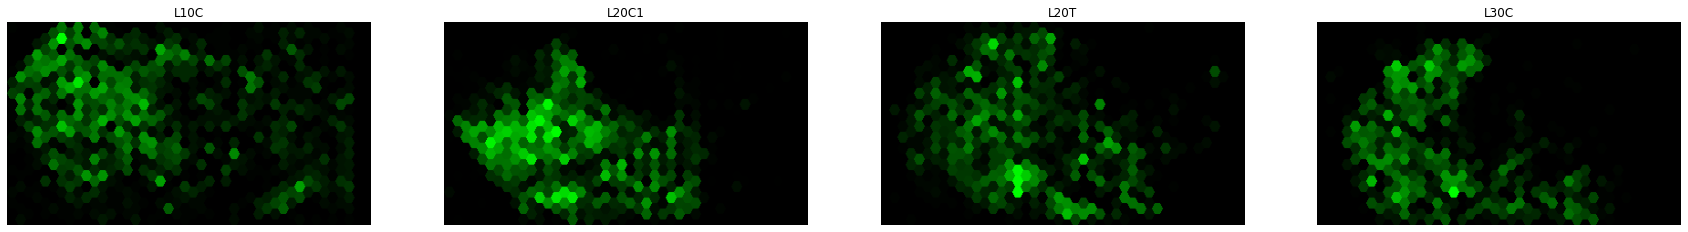

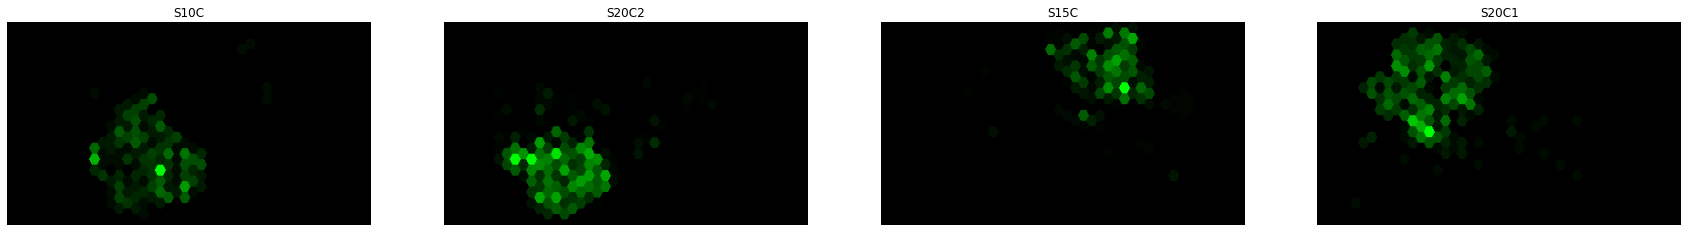

In [25]:
liver_labels = ['L10C', 'L20C1', 'L20T', 'L30C']
spleen_labels = ['S10C', 'S20C2', 'S15C', 'S20C1']
for counts, labels in zip([counts_liver, counts_spleen],
                          [liver_labels, spleen_labels]):
    img_list = list()
    for batch in tqdm(counts.index.get_level_values('batch').unique()):
        color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
        tot = counts.loc[batch].sum(axis=1)
        tot = np.uint8(tot/tot.max()*255)
        color_df['g'] = tot
        img = get_image(color_df)
        img_list.append(img)
    fig, axes = plt.subplots(1,4, figsize=(30,10))
    for img, ax, title in zip(img_list, np.ravel(axes), labels):
        ax.imshow(img);
        ax.set_title(title)
        ax.axis('off')
    plt.show()

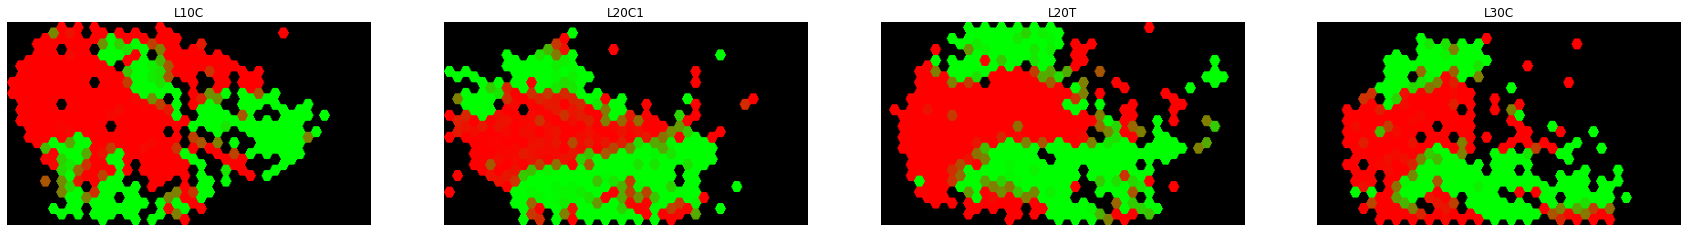

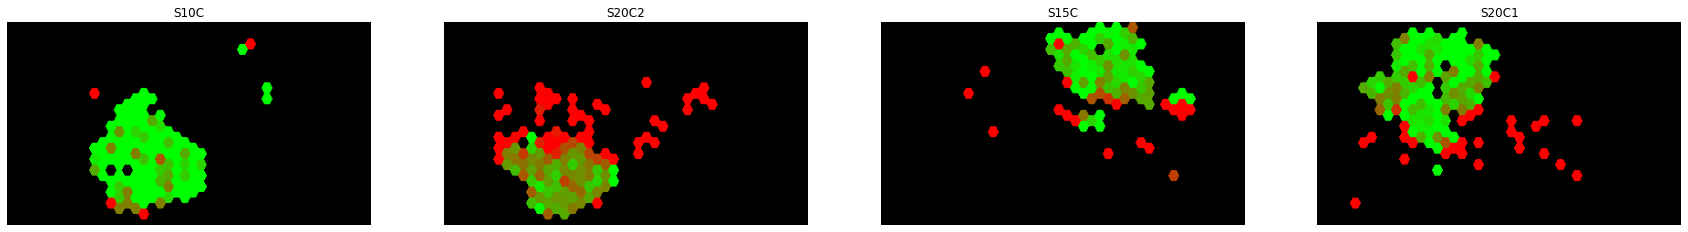

In [58]:
for counts, cts, labels in zip([counts_liver, counts_spleen],
                               [['Hepato', 'MC38'], ['non_mc38', 'mc38']],
                               [liver_labels, spleen_labels]
                              ):
    img_list = list()
    for batch in tqdm(counts.index.get_level_values('batch').unique()):
        color_df = get_colors(counts.loc[batch], cts=cts)
        img = get_image(color_df)
        img_list.append(img)
    fig, axes = plt.subplots(1,4, figsize=(30,10))
    for img, ax, title in zip(img_list, np.ravel(axes), labels):
        ax.imshow(img);
        ax.set_title(title)
        ax.axis('off')
    plt.show()

## Liver

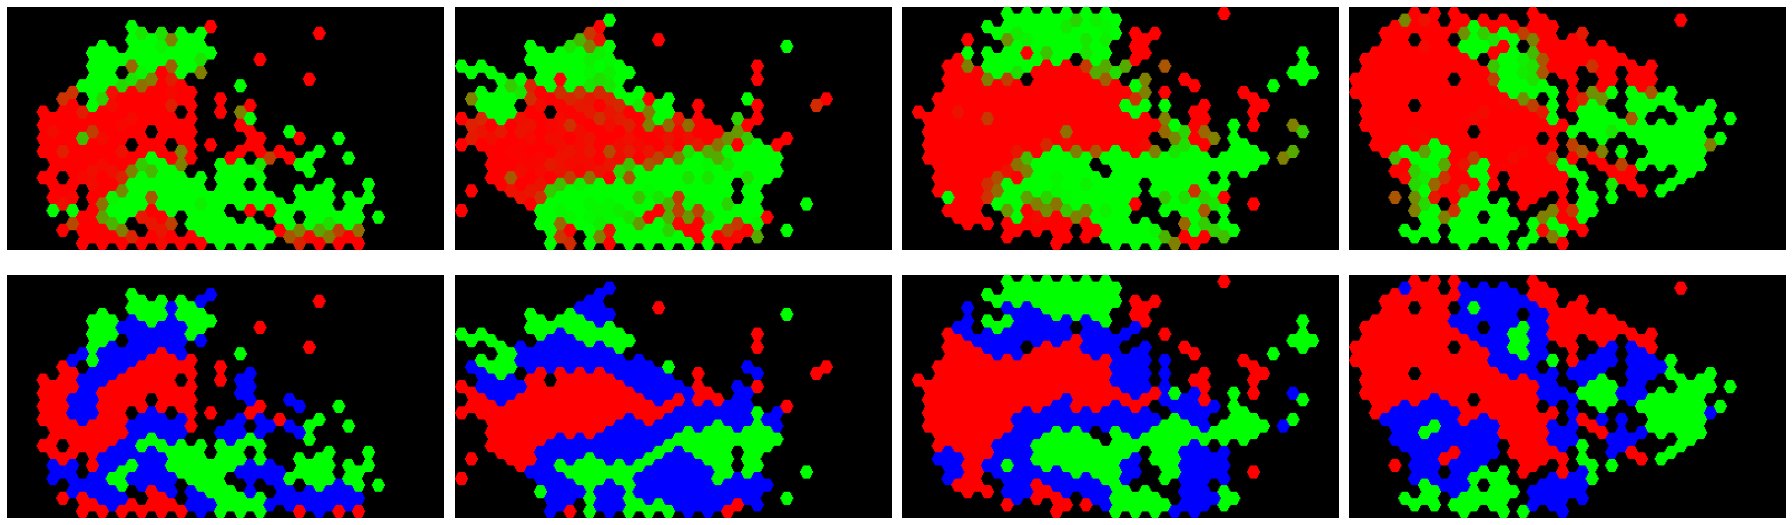

In [166]:
liver_regions = list()
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
for batch, ax_col in tqdm(zip(counts_liver.index.get_level_values('batch').value_counts().index, ax.T)):
    color_df = get_colors(counts_liver.loc[batch], cts=['Hepato', 'MC38'])
    ax_col[0].imshow(get_image(color_df))
    ax_col[0].axis('off');
    for x, y in color_df.index:
        if color_df.loc[(x, y), 'g'] > color_df.loc[(x, y), 'r'] + 50:
            color_df.loc[(x, y), 'g'] = 255
            color_df.loc[(x, y), 'r'] = 0
        elif color_df.loc[(x, y), 'r'] > color_df.loc[(x, y), 'g'] + 50:
            color_df.loc[(x, y), 'r'] = 255
            color_df.loc[(x, y), 'g'] = 0
    border_region = get_layers(set(color_df.index[color_df['r'] == 255].tolist()), 
                               layers=1, 
                               mask=set(color_df.index[~(color_df.sum(1) == 0)].tolist()))[0].union(
        get_layers(set(color_df.index[color_df['g'] == 255].tolist()), 
                   layers=1, 
                   mask=set(color_df.index[~(color_df.sum(1) == 0)].tolist()))[0]
    )
    for x, y in color_df.index:
        if color_df.loc[(x, y), 'g'] > color_df.loc[(x, y), 'r']:
            color_df.loc[(x, y), 'g'] = 255
            color_df.loc[(x, y), 'r'] = 0
        elif color_df.loc[(x, y), 'r'] > color_df.loc[(x, y), 'g']:
            color_df.loc[(x, y), 'r'] = 255
            color_df.loc[(x, y), 'g'] = 0
        if (x, y) in border_region:
            color_df.loc[(x, y)] = [0, 0, 255]
    liver_regions.append(color_df)
    ax_col[1].imshow(get_image(color_df))
    ax_col[1].axis('off');
plt.tight_layout()

## Spleen

### Define the "core" of the MC38 Region

In [167]:
cores = {'S10C': {(17, 17), (17, 16), (17, 15), (16, 16), (18, 16),
                  (13, 16), (21, 16)
                 },
         'S20C2': {(11, 17), (12, 17), (13, 18), (14, 17), (15, 18),
                   (11, 16), (12, 16), (13, 17), (14, 16), (15, 17), (16, 17),
                   (12, 15), (13, 16),
                   (16, 16), (17, 17),
                   (17, 16), (18, 16),
                  },
         'S15C': {(27, 1), (28, 1), (29, 1), (30, 1), (31, 1),
                  (27, 2), (28, 2), (29, 2), (30, 2), (31, 2),
                  (26, 1), (25, 2), (22, 1)},
         'S20C1': {(10, 4), (12, 4), (14, 4), (16, 3), (12, 1),
                   (18, 1)
                  }
        }

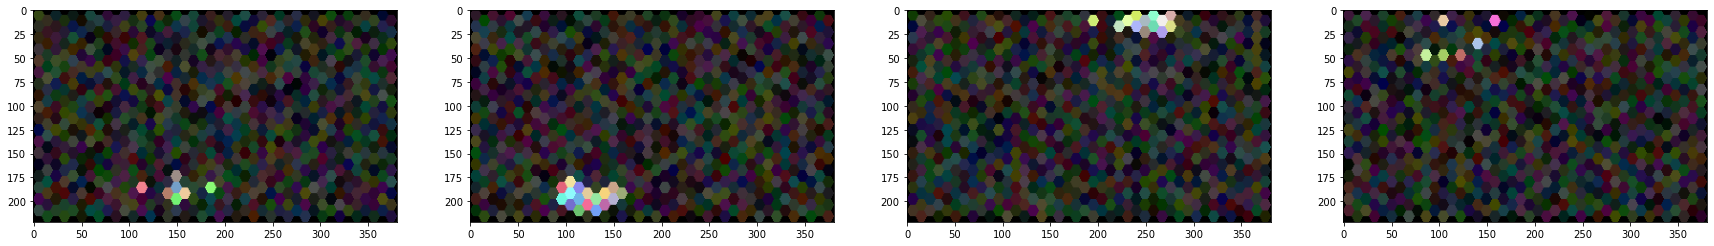

In [168]:
fig, ax =plt.subplots(1, 4, figsize=(30, 10))
for label, ax in zip(['S10C', 'S20C2', 'S15C', 'S20C1'], np.ravel(ax)):
    hex_marked(cores[label], ax=ax);

In [169]:
batch_label = dict(zip(range(4), ['S10C', 'S20C2', 'S15C', 'S20C1']))
layer_threshs = [[5, 9],
                 [4, 7],
                 [4, 9],
                 [5, 10]
                ]

No more layers, returning only 26 layers + center
No more layers, returning only 28 layers + center
No more layers, returning only 28 layers + center
No more layers, returning only 29 layers + center



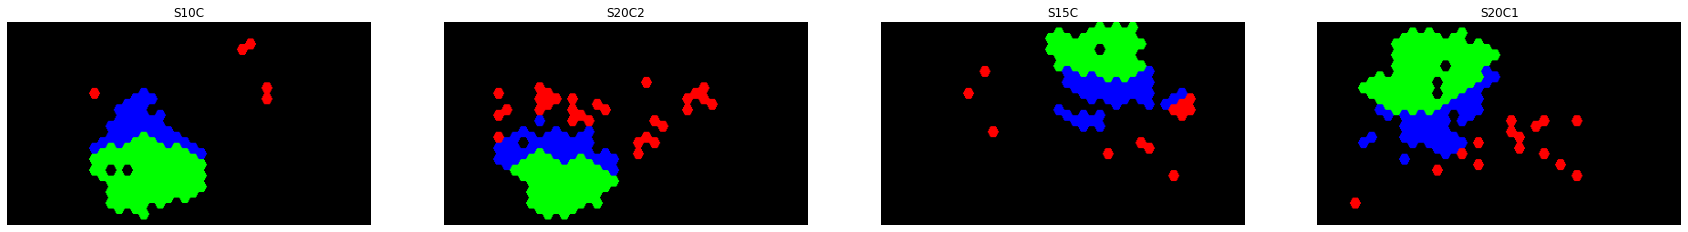

In [170]:
spleen_regions = list()
img_list = list()
num_layers = 30 # this is the most layers anyway
for batch, layer_thresh in tqdm(zip(counts_spleen.index.get_level_values('batch').unique(),
                                    layer_threshs)):
    score_df = pd.DataFrame(0, index = counts_spleen.loc[batch].index, columns = ['r','g','b'])
    layer_count = 0
    for layer, score in zip(get_layers(cores[batch_label[batch]], layers=num_layers, 
                                       include_center=True, 
                                      mask = set(counts_spleen[counts_spleen.sum(axis=1) > 0].loc[batch].index.tolist())), 
                            np.linspace(255, 0, num_layers)):
        layer_count += 1
        if layer_count <= layer_thresh[0]:
            score_df.loc[layer, 'g'] = 255
        elif layer_count <= layer_thresh[1]:
            score_df.loc[layer, 'b'] = 255
        else:
            score_df.loc[layer, 'r'] = 255
    spleen_regions.append(score_df)
    img = get_image(score_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['S10C', 'S20C2', 'S15C', 'S20C1']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

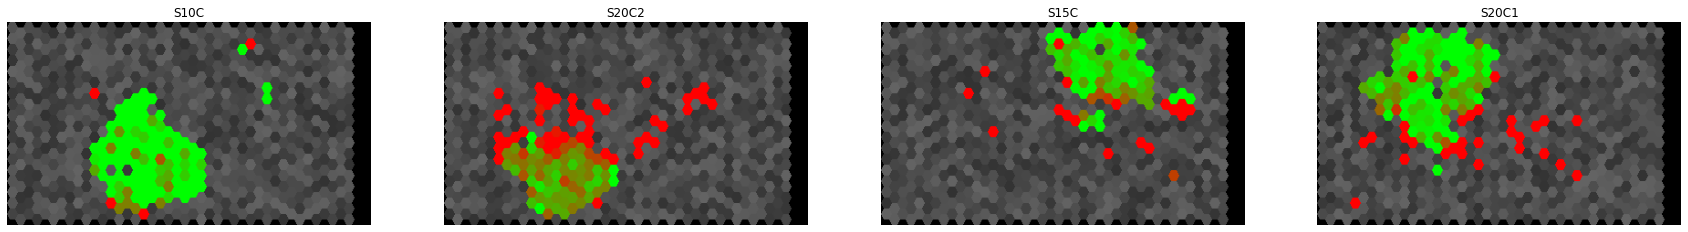

In [97]:
img_list = list()
for batch in tqdm(counts_spleen.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts_spleen.loc[batch], cts=['non_mc38', 'mc38'])
    color_df = add_random_gray_background(color_df)
    img = get_image(color_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['S10C', 'S20C2', 'S15C', 'S20C1']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

## Fill in Regions

In [190]:
liver_regions_df = pd.DataFrame(0, index=counts_liver.index, columns=['region'])
liver_regions_labels = list()

In [191]:
for batch in tqdm(counts_liver.index.get_level_values('batch').unique()):
    for x, y in liver_regions[batch].index:
        if liver_regions[batch].loc[(x, y)].sum() == 0:
            liver_regions_labels.append(-1)
        elif liver_regions[batch].loc[(x, y), 'g'].sum() == 255:
            liver_regions_labels.append(0)
        elif liver_regions[batch].loc[(x, y), 'b'].sum() == 255:
            liver_regions_labels.append(1)
        elif liver_regions[batch].loc[(x, y), 'r'].sum() == 255:
            liver_regions_labels.append(2)
        else:
            assert False, "PROBLEM"
liver_regions_df['region'] = liver_regions_labels

In [192]:
spleen_regions_df = pd.DataFrame(0, index=counts_spleen.index, columns=['region'])
spleen_regions_labels = list()

In [193]:
for batch in tqdm(counts_spleen.index.get_level_values('batch').unique()):
    for x, y in spleen_regions[batch].index:
        if spleen_regions[batch].loc[(x, y)].sum() == 0:
            spleen_regions_labels.append(-1)
        elif spleen_regions[batch].loc[(x, y), 'g'].sum() == 255:
            spleen_regions_labels.append(0)
        elif spleen_regions[batch].loc[(x, y), 'b'].sum() == 255:
            spleen_regions_labels.append(1)
        elif spleen_regions[batch].loc[(x, y), 'r'].sum() == 255:
            spleen_regions_labels.append(2)
        else:
            assert False, "PROBLEM"
spleen_regions_df['region'] = spleen_regions_labels

In [198]:
spleen_regions_df['region'].value_counts().sort_index()

-1    2570
 0     246
 1     146
 2      62
Name: region, dtype: int64

In [199]:
liver_regions_df['region'].value_counts().sort_index()

-1    1489
 0     385
 1     623
 2     527
Name: region, dtype: int64

In [201]:
spleen_regions_df.to_pickle('/data/xyzeq/tissue.regions.pkls/spleen.regions.pkl')
liver_regions_df.to_pickle('/data/xyzeq/tissue.regions.pkls/liver.regions.pkl')